# Description

This notebook shows some exasmples of my data visualization work with Python. Time by time I will append new graphs here. 

I use syntetic data of imagine products sales in different regions and clients. 

## Data import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

In [23]:
data = pd.read_csv('data/sales.csv', sep=';')
data['date'] = data['date'].astype('datetime64')

print(data.shape)
data.head()

(14232, 13)


,date,region,prod_id,prod_name,client,Year,year_month,price_mean,weight_fact,discount_mean,stores_num,hasPromo,weight_predict
0,2019-03-01,region_0,57406,prod_name_14,client_10,2019,3,68.64,26.18,18.0,13,1,22.489067
1,2019-03-01,region_1,57406,prod_name_14,client_10,2019,3,82.06,4.63,0.0,4,0,-3.869824
2,2019-03-01,region_5,57481,prod_name_12,client_10,2019,3,140.83,49.23,1.0,24,0,44.314210
3,2019-03-02,region_5,57481,prod_name_12,client_1,2019,3,78.92,5160.86,29.0,1943,1,4280.262168
4,2019-03-01,region_5,57479,prod_name_3,client_1,2019,3,34.45,3424.86,40.0,1779,1,3251.500504


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14232 entries, 0 to 14231
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            14232 non-null  datetime64[ns]
 1   region          14232 non-null  object        
 2   prod_id         14232 non-null  int64         
 3   prod_name       14232 non-null  object        
 4   client          14232 non-null  object        
 5   Year            14232 non-null  int64         
 6   year_month      14232 non-null  int64         
 7   price_mean      14232 non-null  float64       
 8   weight_fact     14232 non-null  float64       
 9   discount_mean   14232 non-null  float64       
 10  stores_num      14232 non-null  int64         
 11  hasPromo        14232 non-null  int64         
 12  weight_predict  14232 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(3)
memory usage: 1.4+ MB


## Plots

### Functions

In [51]:
def last_Nmonth(dates, nmonth):
    last_date = dates.max()
    first_date = last_date - pd.Timedelta(30*nmonth - 10, unit='D')
    first_date - pd.Timedelta(first_date.day-1, unit='D')
    return (first_date, last_date)

In [25]:
def Lineplot_WithPromo(frame:pd.DataFrame, X:str, y:list, ax:plt.axes, promo_cols=None, style_dict=None, colors=['b', 'r', 'g', 'y']):
    '''
    Function draws 2 lines to compare Fact and Predict values by X-axis(for example by "date").
    You can add extra parameter "promo_cols", to highlight Promo days.
    '''

    if not isinstance(y, list):
        raise ValueError('"y" parameter should be list')
    if len(y) > 2:
        raise ValueError('length of "y" parameter not should be more than 2')
    if not isinstance(X, str):
        raise ValueError('"X" parameter should be string')
    if not isinstance(frame, pd.DataFrame):
        raise ValueError('"frame" parameter should be DataFrame')

    legend_desc = ['Fact', 'Predict', 'Promo']
    for ind, value in enumerate(y):
        sns.lineplot(data=frame, x=X, y=value, ax=ax, color=colors[ind], estimator='sum', ci=None)
    
    if promo_cols is not None:
        if isinstance(promo_cols, str):
            promo_cols = [promo_cols]
        if not isinstance(promo_cols, list):
            raise ValueError('"promo_cols" parameter should be string or list')
        # if not isinstance(frame[X]):
        cols = [X] + promo_cols
        for date, promo in frame[cols].to_numpy():
            if promo:
                ax.axvspan(date, date + pd.DateOffset(1), color=colors[2], alpha=0.1)
    
    ax.legend(legend_desc, loc='upper right')


In [26]:
def JoinedBarPlot(data:pd.DataFrame, x:list, y:str, hue:str, hue_order:list, fig, gs, font:dict, palette):
    '''
    Function draws 2 joined barplot to show different metrics for similar categories.
    '''

    if not isinstance(x, list):
        raise ValueError('"x" parameter should be list')
    if len(x) != 2:
        raise ValueError('length of "x" parameter not should equal 2')
    if not isinstance(y, str):
        raise ValueError('"y" parameter should be string')
    if not isinstance(hue, str):
        raise ValueError('"y" parameter should be string')
    if not isinstance(hue_order, (list, np.ndarray)):
        raise ValueError('"hue_order" parameter should be list')
    if not isinstance(data, pd.DataFrame):
        raise ValueError('"data" parameter should be DataFrame')
    if not isinstance(font, dict):
        raise ValueError('"font" parameter should be dictionary')

    sns.set_palette(palette)
    sns.set_style('whitegrid')
    
    for idx, value in enumerate(x):
        ax_ = fig.add_subplot(gs[idx])
        sns.barplot(data=data, y=y, x=value, hue=hue, hue_order=hue_order, estimator=np.mean, ax=ax_, orient='h', ci=None)
        ax_.set_title(f'Mean {value}', fontdict=font['title'])
        ax_.set_xlabel('')

        for i, cat in enumerate(hue_order):
            labels = data.loc[data[hue]  == cat, [y, value]]\
                .groupby([y]).agg('mean')\
                .to_numpy().reshape(1,-1)[0]
            labels = list(map(lambda z: f'{z:,.2f}', labels))
            ax_.bar_label(container=ax_.containers[i], labels=labels, label_type='center', color=palette[-1])
        
        if idx == 0:
            ax_.invert_xaxis()
            ax_.set_ylabel(f'{y} number', fontdict=font['lable'])
            ax_.legend(loc='upper left', fontsize='large')
        else:
            # ax_.set_ylabel('', fontdict=font['lable'])
            ax_.get_yaxis().set_visible(False)
            ax_.get_legend().set_visible(False)

### Draw graphs

In [27]:
UniqValues = {}

for col in ['prod_name', 'region', 'client']:
    uniq = data[col].unique()
    UniqValues[col] = uniq
    print(f'Unique "{col}": {", ".join(map(str, uniq))}')

Unique "prod_name": prod_name_14, prod_name_12, prod_name_3
Unique "region": region_0, region_1, region_5
Unique "client": client_10, client_1


#### Dynamic sales with promo dates by products

In [28]:
palette = sns.color_palette('RdYlBu')
palette

[(0.8899653979238754, 0.2867358708189158, 0.19815455594002307),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6153018069973087),
 (0.9118031526336026, 0.9658592848904267, 0.9111880046136099),
 (0.6409842368319879, 0.8272971933871589, 0.90080738177624),
 (0.346482122260669, 0.5492502883506344, 0.7527104959630911)]

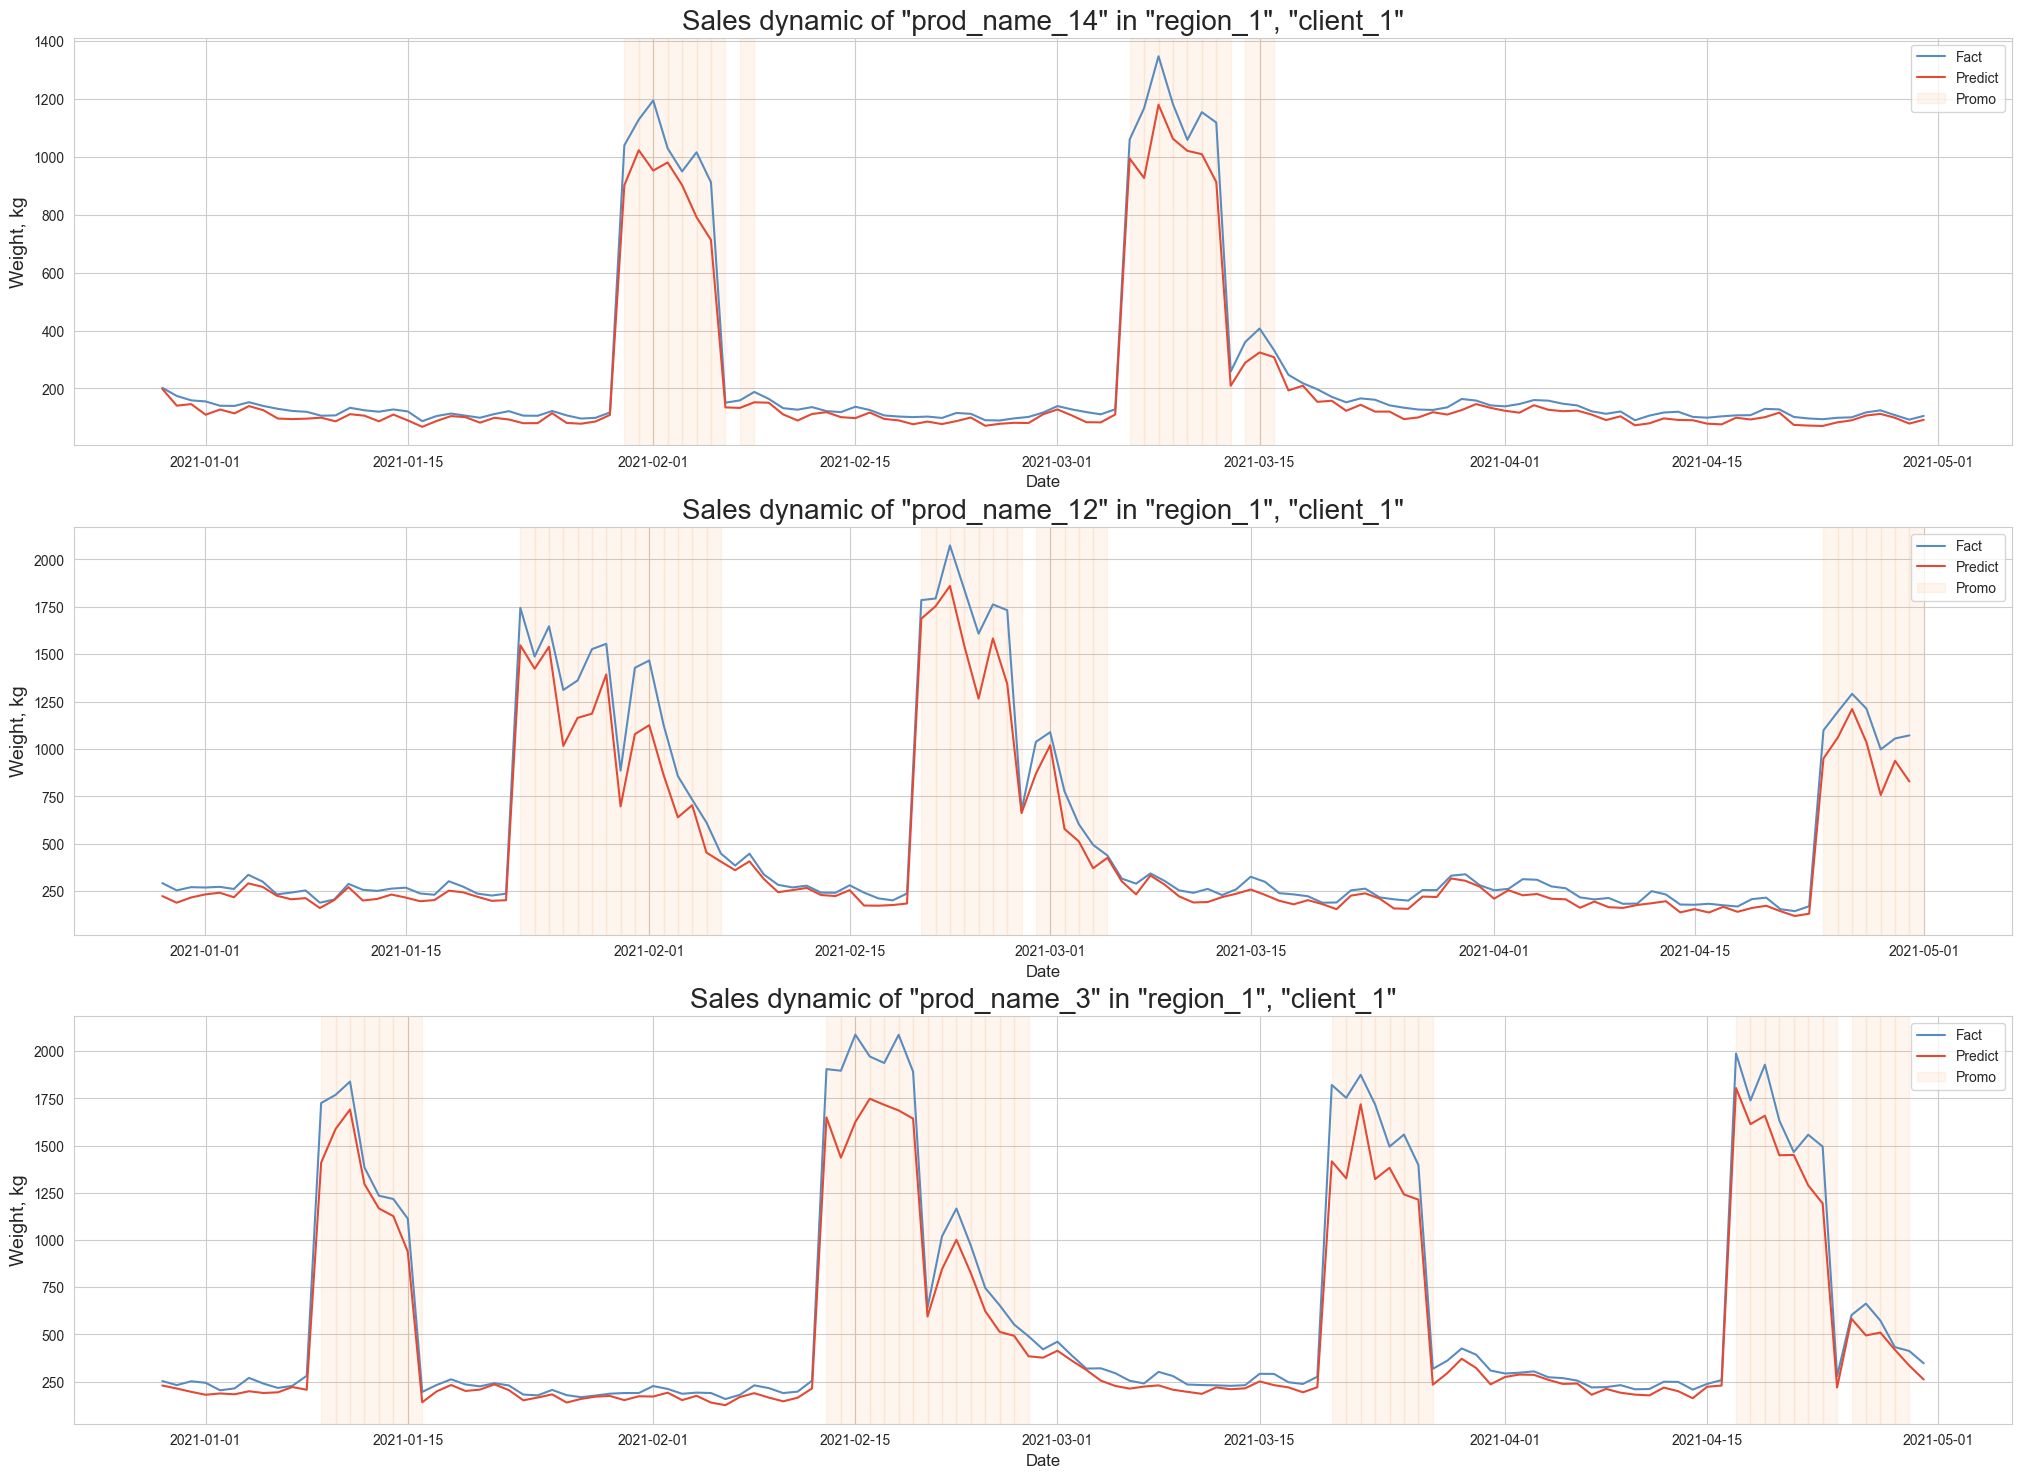

In [29]:
products, region, client = UniqValues['prod_name'], UniqValues['region'][1], UniqValues['client'][1] 
df_filtered = data.loc[(data.region == region) & (data.client == client), ]
nrows = len(products)
fig, ax = plt.subplots(figsize=(25,6*nrows), nrows=nrows)
 
last_4months = last_3months = last_Nmonth(data.date, 4)
colors = [palette[i] for i in (-1, 0, 1)]

for idx, product in enumerate(products):
    ax_ = ax[idx]
    df_plot = df_filtered.loc[(data.prod_name == product)  & (data.date.between(*last_4months)), ]
    Lineplot_WithPromo(df_plot, X='date', y=['weight_fact', 'weight_predict'], ax=ax_, promo_cols=['hasPromo'], colors=colors)

    ax_title = f'Sales dynamic of "{product}" in "{region}", "{client}"'
    ax_.set_title(ax_title, fontsize=20)
    ax_.set_ylabel('Weight, kg', size=14)
    ax_.set_xlabel('Date', size=12)

#### Regions

In [30]:
palette = sns.color_palette('YlGnBu')
palette

[(0.9101268742791234, 0.9649365628604383, 0.6956401384083045),
 (0.6984544405997694, 0.8818608227604767, 0.7138485198000769),
 (0.39601691657054977, 0.7660745866974241, 0.7481430219146482),
 (0.1729642445213379, 0.6295117262591311, 0.759523260284506),
 (0.12764321414840446, 0.42666666666666664, 0.6861361014994233),
 (0.14357554786620533, 0.22523644752018454, 0.5905420991926182)]

Text(0.5, 0.98, 'Compare weight and stores for "prod_name_14" by regions, "client_1"')

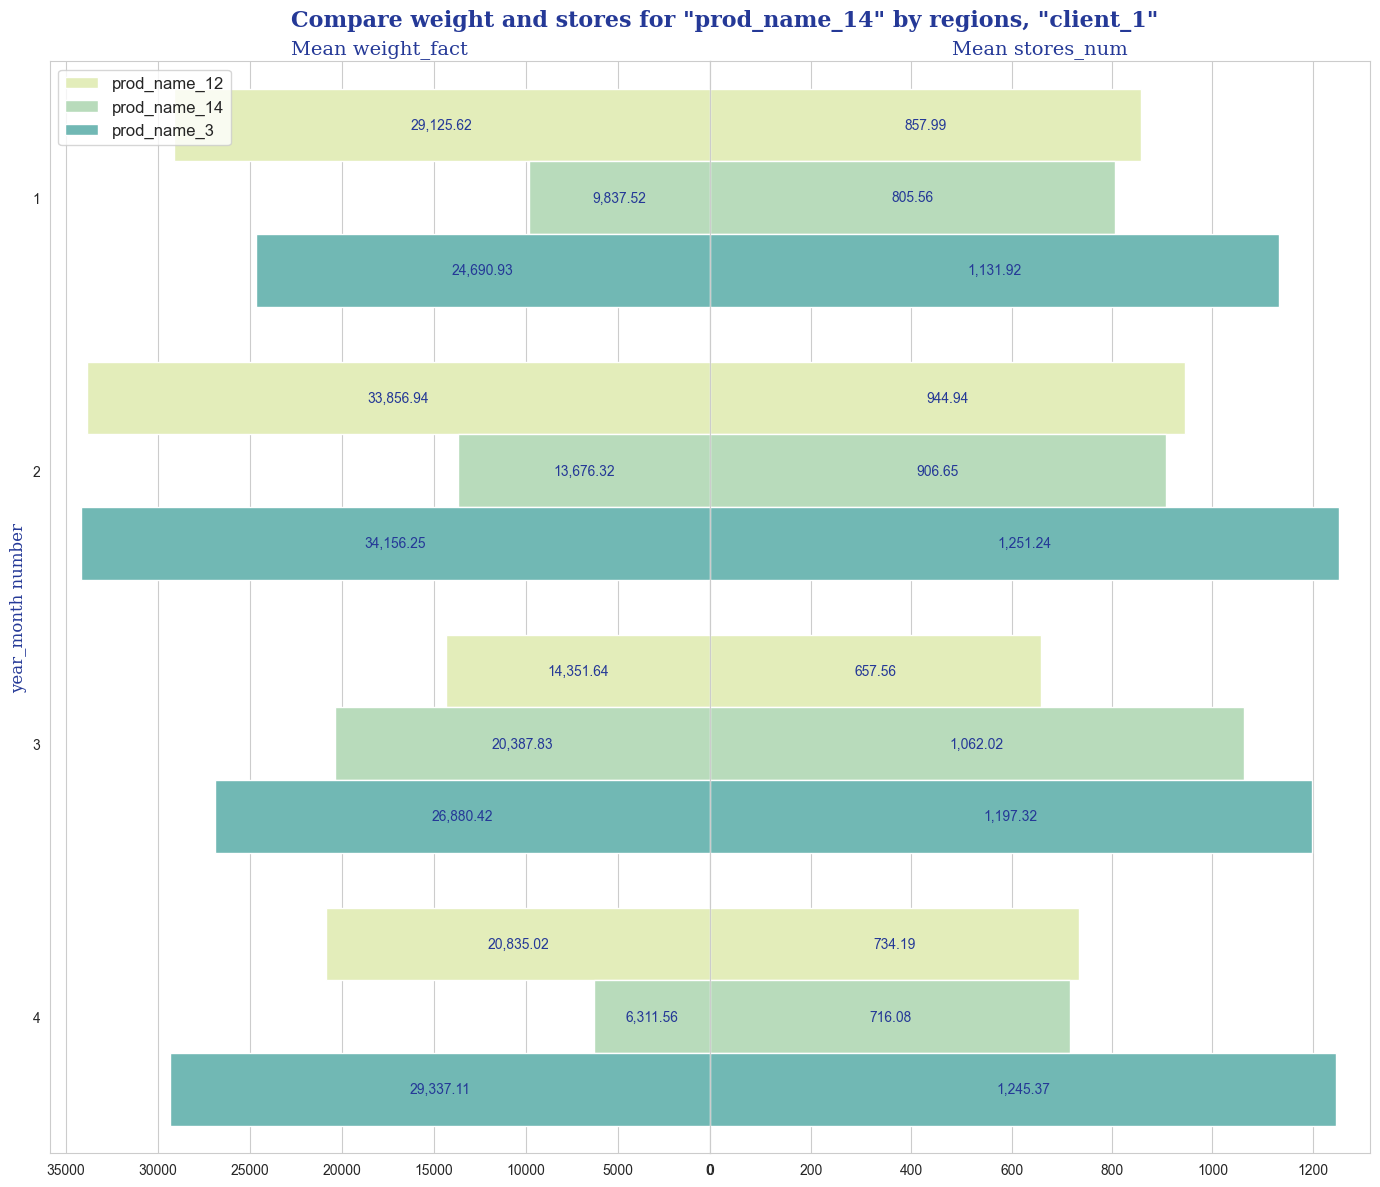

In [31]:
product, client, year = UniqValues['prod_name'][0], UniqValues['client'][1], 2021

df_plot = data.loc[(data.client == client) & (data['Year'] == year)]\
    .groupby(['region', 'prod_name', 'Year', 'year_month'])\
    .agg({'weight_fact': 'sum', 'stores_num': 'mean'})\
    .reset_index()

font = {
    'title': {
        'family': 'serif',
        'fontsize': 14,
        'color': palette[-1],
    },
    'lable': {
        'family': 'serif',
        'fontsize': 12,
        'color': palette[-1],
    },
    'suptitle': {
        'family': 'serif',
        'size': 16,
        'weight': 'bold'
    },
}

fig = plt.figure(figsize=(15,13))
gs = GridSpec(1, 2, figure=fig, wspace=0.001, width_ratios=[1,1], left=0.05, right=0.93, top=0.94, bottom=0.1)
products = df_plot.prod_name.unique()

JoinedBarPlot(df_plot, x=['weight_fact', 'stores_num'], y='year_month', hue='prod_name', hue_order=products, fig=fig, gs=gs, font=font, palette=palette)
fig.suptitle(f'Compare weight and stores for "{product}" by regions, "{client}"', fontproperties=font['suptitle'], color=palette[-1])


### Other

In [32]:
palette = sns.color_palette('Spectral')
palette

[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Prediction result for "prod_name_14" in "client_1"')

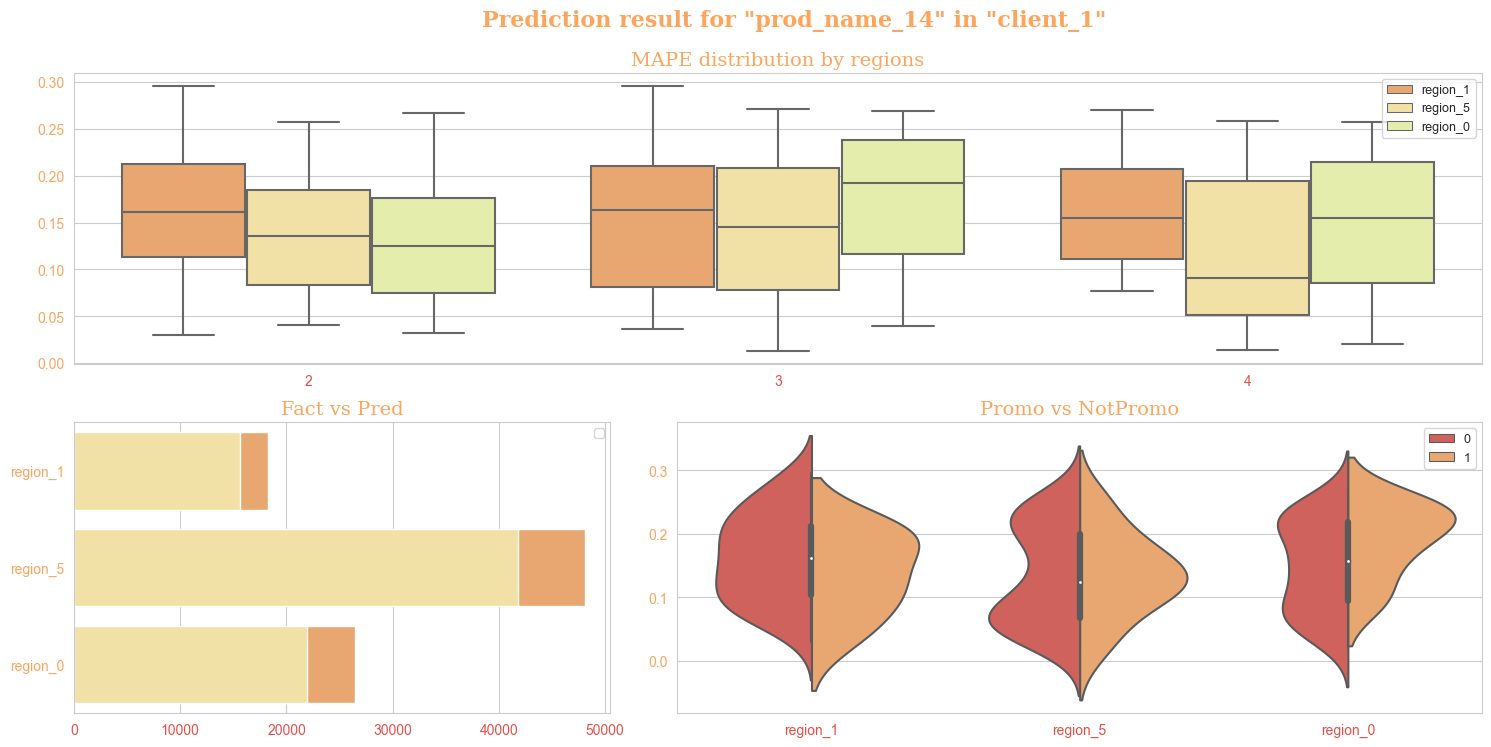

In [52]:
# from sklearn.metrics import mean_absolute_percentage_error as mape
def mape(fact, pred):
    return np.abs(fact - pred)/ fact

font = {
    'title': {
        'family': 'serif',
        'fontsize': 14,
        'color': palette[1],
    },
    'label': {
        'family': 'serif',
        'fontsize': 12,
        'color': palette[1],
    },
    'suptitle': {
        'family': 'serif',
        'size': 16,
        'weight': 'bold'
    },
}

product, client, year = UniqValues['prod_name'][0], UniqValues['client'][1], 2021
clients = UniqValues['client']

last_3months = last_Nmonth(data.date, 3)

df_mape = data.loc[
    (data.prod_name == product) & (data.date.between(*last_3months))
    ].copy()
df_mape['mape'] = mape(df_mape.weight_fact, df_mape.weight_predict)
df_plot = df_mape.loc[df_mape.client == client]

fig = plt.figure(figsize=(16,8))
gs = GridSpec(2, 2, figure=fig, wspace=0.1, width_ratios=[2, 3], height_ratios=[1,1], left=0.05, right=0.93, top=0.9, bottom=0.1)
sns.set_palette(palette)
sns.set_style('whitegrid')
ax = []

ax_ = fig.add_subplot(gs[0, :])
ax.append(ax_)

sns.boxplot(data=df_plot, y='mape', x='year_month', hue='region', ax=ax_, palette=palette[1:])
# ax_.set_title()
ax_.set_ylabel('MAPE', fontdict=font['label'])
# ax_.legend(loc='upper right', fontsize=9)
ax_.set_title('MAPE distribution by regions', fontdict=font['title'])

ax_ = fig.add_subplot(gs[1, 0])
ax.append(ax_)
sns.barplot(data=df_plot, x='weight_fact', y='region', estimator=np.sum, ci=None, ax=ax_, color=palette[1])
sns.barplot(data=df_plot, x='weight_predict', y='region', estimator=np.sum, ci=None, ax=ax_, color=palette[2])
ax_.set_title('Fact vs Pred', fontdict=font['title'])

ax_ = fig.add_subplot(gs[1, 1])
ax.append(ax_)
sns.violinplot(data=df_plot, x='region', y='mape', hue='hasPromo', split=True)
ax_.set_title('Promo vs NotPromo', fontdict=font['title'])
# ax_.legend(loc='upper right', fontsize=9)

for ax_ in ax:
    ax_.set_xlabel('')
    ax_.set_ylabel('')
    ax_.tick_params(axis='x', colors=palette[0])
    ax_.tick_params(axis='y', colors=palette[1])
    ax_.legend(loc='upper right', fontsize=9)


fig.suptitle(f'Prediction result for "{product}" in "{client}"', fontproperties=font['suptitle'], color=palette[1])

# plt.plot()